In [1]:
from __future__ import division
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics import log_loss
import pandas as pd 
import numpy as np
import xgboost as xgb
import math
import nltk
from nltk import ngrams
from sklearn.cross_validation import train_test_split
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from simhash import Simhash
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import pyplot
from sklearn.manifold import TSNE
import pickle
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import spacy
nlp = spacy.load('en')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
0it [00:00, ?it/s]


In [2]:
question_types = ["what", "how", "why", "is", "which", "can", "i", "who", "do", "where", "if", "does", "are", "when", "should", "will", "did", "has", "would", "have", "was", "could"]

In [3]:

def submit(p_test):

    sub = pd.DataFrame()

    sub['test_id'] = df_test['test_id']
    sub['is_duplicate'] = p_test

    sub.to_csv('simple_xgb.csv', index=False)   

def get_inverse_freq(inverse_freq, count, min_count=2):

    if count < min_count:   
        return 0
    else:
        return inverse_freq

def get_tf(text):

    tf = {}

    for word in text:
        tf[word] = text.count(word)/len(text)

    return tf

def tuple_similarity(q1_words, q2_words):

    if len(q1_words) == 0 or len(q2_words) == 0:
        return 0

    common_words = len(set(q1_words).intersection(set(q2_words)))
    all_words = len(set(q1_words).union(set(q2_words)))

    return common_words/all_words

def get_ne_score(row):

    q1_words = str(row.question1).lower().split()
    q2_words = str(row.question2).lower().split()

    # all_words_score = np.sum([weights.get(w, 0) for w in q1_words]) + np.sum([weights.get(w, 0) for w in q2_words])

    q1 = nlp(unicode(str(row["question1"]), "utf-8"))
    q2 = nlp(unicode(str(row["question2"]), "utf-8"))

    q1_ne = q1.ents
    q2_ne = q2.ents

    q1_ne = set([str(i) for i in q1_ne])
    q2_ne = set([str(i) for i in q2_ne])

    if len(q1_ne) == 0:
        q1_ne_ratio = 0
    else:
        q1_ne_ratio = len(q1_ne)/len(q1_words)

    if len(q2_ne) == 0:
        q2_ne_ratio = 0
    else:
        q2_ne_ratio = len(q2_ne)/len(q2_words)

    common_ne = list(q1_ne.intersection(q2_ne))
    # common_ne_weights = np.sum([weights.get(w, 0) for w in common_ne])

    if len(q1_ne) + len(q2_ne) == 0:
        common_ne_score = 0
    else:
       common_ne_score = len(common_ne)/(len(q1_words) + len(q2_words) - len(common_ne))

    return pd.Series({
        "q1_ne_ratio": q1_ne_ratio,
        "q2_ne_ratio": q2_ne_ratio,
        "ne_diff": abs(q1_ne_ratio - q2_ne_ratio),
        "ne_score": common_ne_score
    })


def basic_nlp(row):

    # q1_tf = get_tf(q1_words)
    # q2_tf = get_tf(q2_words)
    
    q1_words = str(row.question1).lower().split()
    q2_words = str(row.question2).lower().split()

    #modify this!
    if len(q1_words) == 0 or len(q2_words) == 0:
        return 0

    common_words = list(set(q1_words).intersection(q2_words))
    
    common_words_score = np.sum([weights.get(w, 0) for w in common_words])
    all_words_score = np.sum([weights.get(w, 0) for w in q1_words]) + np.sum([weights.get(w, 0) for w in q2_words]) - common_words_score

    hamming_score = sum(1 for i in zip(q1_words, q2_words) if i[0]==i[1])/max(len(q1_words), len(q2_words))

    jacard_score =  len(common_words)/(len(q1_words) + len(q2_words) - len(common_words))  
    cosine_score = len(common_words)/(pow(len(q1_words),0.5)*pow(len(q2_words),0.5))

    bigrams_q1 = set(ngrams(q1_words, 2))
    bigrams_q2 = set(ngrams(q2_words, 2))
    common_bigrams = len(bigrams_q1.intersection(bigrams_q2))
    if common_bigrams == 0:
        bigram_score = 0
    else:
        bigram_score = common_bigrams/(len(bigrams_q1.union(bigrams_q2)))    

    trigrams_q1 = set(ngrams(q1_words, 3))
    trigrams_q2 = set(ngrams(q2_words, 3))
    common_trigrams = len(trigrams_q1.intersection(trigrams_q2))
    if common_trigrams == 0:
        trigram_score = 0
    else:
        trigram_score = common_trigrams/(len(trigrams_q1.union(trigrams_q2)))    

    # sequence1 = get_word_bigrams(q1_words)
    # sequence2 = get_word_bigrams(q2_words)

    # try:
    #     simhash_diff = Simhash(sequence1).distance(Simhash(sequence2))/64
    # except:
    #     simhash_diff = 0.5

    q1 = nlp(unicode(str(row["question1"]), "utf-8"))
    q2 = nlp(unicode(str(row["question2"]), "utf-8"))

    q1_ne = q1.ents
    q2_ne = q2.ents

    q1_ne = set([str(i) for i in q1_ne])
    q2_ne = set([str(i) for i in q2_ne])

    if len(q1_ne) == 0:
        q1_ne_ratio = 0
    else:
        q1_ne_ratio = len(q1_ne)/len(q1_words)

    if len(q2_ne) == 0:
        q2_ne_ratio = 0
    else:
        q2_ne_ratio = len(q2_ne)/len(q2_words)

    common_ne = list(q1_ne.intersection(q2_ne))
    # common_ne_weights = np.sum([weights.get(w, 0) for w in common_ne])

    if len(q1_ne) + len(q2_ne) == 0:
        common_ne_score = 0
    else:
       common_ne_score = len(common_ne)/(len(q1_words) + len(q2_words) - len(common_ne))

    pos_hash = {}
    common_pos = []

    for word in q1:
        if word.tag_ not in pos_hash:
            pos_hash.update({word.tag_ : [word.text]})
        else:
            pos_hash[word.tag_].append(word.text)

    for word in q2:
        if word.tag_ not in pos_hash:
            continue
        if word.text in pos_hash[word.tag_]:
            common_pos.append(word.text)

    common_pos_score = np.sum([weights.get(w, 0) for w in common_pos])
    all_pos_score = np.sum([weights.get(w, 0) for w in q1_words]) + np.sum([weights.get(w, 0) for w in q2_words]) - common_pos_score

    q1_pronouns_count = 0
    q2_pronouns_count = 0

    for word in q1:
        if str(word.tag_) == "PRP":
            q1_pronouns_count += 1

    for word in q2:
        if str(word.tag_) == "PRP":
            q2_pronouns_count += 1

    pronouns_diff = abs(q1_pronouns_count - q2_pronouns_count)

    q1_nc = q1.noun_chunks
    q2_nc = q2.noun_chunks

    q1_nc = set([str(i) for i in q1_nc])
    q2_nc = set([str(i) for i in q2_nc])

    common_nc = len(q1_nc.intersection(q2_nc))

    if len(q1_nc) + len(q2_nc) == 0:
        common_nc_score = 0
    else:
       common_nc_score = common_nc/(len(q1_nc) + len(q2_nc) - common_nc)

    fw_q1 = q1_words[0]
    fw_q2 = q2_words[0]

    if fw_q1 == fw_q2 and fw_q1 in question_types:
        question_type_same = 1
    else:
        question_type_same = 0

    try:
        q1_quotes = len(re.findall(r'\"(.+?)\"', row["question1"]))
    except:
        q1_quotes = 0

    try:
        q2_quotes = len(re.findall(r'\"(.+?)\"', row["question2"]))
    except:
        q2_quotes = 0

    # if len(q1_ne) == 0:
    #     q1_ne_hash_freq = 1
    # else:
    #     hash_key1 = hash("-".join(set([str(i).lower() for i in q1_ne])))

    #     if hash_key1 not in hash_table_ne:
    #         q1_ne_hash_freq = 1
    #     else:
    #         q1_ne_hash_freq = hash_table_ne[hash_key1]

    # if len(q2_ne) == 0:
    #     q2_ne_hash_freq = 1
    # else:
    #     hash_key2 = hash("-".join(set([str(i).lower() for i in q2_ne])))

    #     if hash_key2 not in hash_table_ne:
    #         q2_ne_hash_freq = 1
    #     else:
    #         q2_ne_hash_freq = hash_table_ne[hash_key2]

    try:
        q1_sents = len(nltk.tokenize.sent_tokenize(row.question1))
    except:
        q1_sents = 1
    try:
        q2_sents = len(nltk.tokenize.sent_tokenize(row.question2))
    except:
        q2_sents = 1

    q1_exclaim = sum([1 for i in str(row.question1) if i == "!"])
    q2_exclaim = sum([1 for i in str(row.question2) if i == "!"])

    q1_question = sum([1 for i in str(row.question1) if i == "?"])
    q2_question = sum([1 for i in str(row.question2) if i == "?"])

    hash_key1 = hash(str(row["question1"]).lower())
    if hash_key1 in hash_table:
        q1_hash_freq = hash_table[hash_key1]
    else:
        q1_hash_freq = 1

    hash_key2 = hash(str(row["question2"]).lower())
    if hash_key2 in hash_table:
        q2_hash_freq = hash_table[hash_key2]
    else:
        q2_hash_freq = 1

    # if hash_key1 in pos_hash_table:
    #     q1_dup_ratio = pos_hash_table[hash_key1]/q1_hash_freq
    # else:

    #     q1_dup_ratio = 0

    # if hash_key2 in pos_hash_table:
    #     q2_dup_ratio = pos_hash_table[hash_key2]/q2_hash_freq
    # else:
    #     q2_dup_ratio = 0

    spacy_sim = q1.similarity(q2)

    return pd.Series({

        "weighted_word_match_ratio" : common_words_score/all_words_score,
        "weighted_word_match_diff": all_words_score - common_words_score, 
        "weighted_word_match_sum": common_words_score,
        "jacard_score": jacard_score,
        "hamming_score": hamming_score,
        "cosine_score": cosine_score,
        "bigram_score": bigram_score,
        "trigram_score": trigram_score,
        "pos_score": common_pos_score/all_pos_score,
        # "simhash_diff": simhash_diff,
        "question_type_same": question_type_same,
        "q1_stops": len(set(q1_words).intersection(stops))/len(q1_words),
        "q2_stops": len(set(q2_words).intersection(stops))/len(q2_words),
        "q1_len": len(str(row.question1)),
        "q2_len": len(str(row.question2)),
        "len_diff": abs(len(str(row.question1)) - len(str(row.question2))),
        "len_avg": (len(str(row.question1)) + len(str(row.question2)))/2,
        "q1_sents": q1_sents,
        "q2_sents": q2_sents,
        "sents_diff": abs(q1_sents - q2_sents),
        "q1_words": len(q1_words),
        "q2_words": len(q2_words),
        "words_diff": abs(len(q1_words) - len(q2_words)),
        "words_avg": (len(q1_words) + len(q2_words))/2,
        "q1_caps_count": sum([1 for i in str(row.question1) if i.isupper()]),
        "q2_caps_count": sum([1 for i in str(row.question2) if i.isupper()]),
        "q1_exclaim": q1_exclaim,
        "q2_exclaim": q2_exclaim,
        "exclaim_diff": abs(q1_exclaim - q2_exclaim),
        "q1_question": q1_question,
        "q2_question": q2_question,
        "question_diff": abs(q1_question - q2_question),
        "ne_score": common_ne_score,
        "nc_score": common_nc_score,
        "q1_ne_ratio": q1_ne_ratio,
        "q2_ne_ratio": q2_ne_ratio,
        "ne_diff": abs(q1_ne_ratio - q2_ne_ratio),
        "q1_quotes": q1_quotes,
        "q2_quotes": q2_quotes,
        "quotes_diff": abs(q1_quotes - q2_quotes),
        # "q1_ne_hash_freq": q1_ne_hash_freq,
        # "q2_ne_hash_freq": q2_ne_hash_freq,
        # "chunk_hash_diff": abs(q1_ne_hash_freq - q2_ne_hash_freq),
        "q1_hash_freq": q1_hash_freq,
        "q2_hash_freq": q2_hash_freq,
        "q_freq_avg": (q1_hash_freq + q2_hash_freq)/2,
        "freq_diff": abs(q1_hash_freq - q2_hash_freq),
        "spacy_sim": spacy_sim,
        "q1_pronouns_count": q1_pronouns_count,
        "q2_pronouns_count": q2_pronouns_count,
        "pronouns_diff": pronouns_diff
        # "q1_dup_ratio": q1_dup_ratio,
        # "q2_dup_ratio": q2_dup_ratio,
        # "q1_q2_dup_ratio_avg": (q1_dup_ratio + q2_dup_ratio)/2
    })

def neighbor_intersection(row):

    q1_neighbors = graph[row["question1"]]
    q2_neighbors = graph[row["question2"]]

    common_neighbors = set(q1_neighbors).intersection(q2_neighbors)
    prni
    return len(common_neighbors)

def get_q1_second_degree_freq(row):

    q1_neighbors = graph[row["question1"]]

    q1_second_degree_neighbors = []
    for i in q1_neighbors:
        q1_second_degree_neighbors += graph[i]

    return len(set(q1_second_degree_neighbors))

def get_q2_second_degree_freq(row):

    q2_neighbors = graph[row["question2"]]

    q2_second_degree_neighbors = []
    for i in q2_neighbors:
        q2_second_degree_neighbors += graph[i]

    return len(set(q2_second_degree_neighbors))


def second_degree_intersection(row):

    q1_neighbors = graph[row["question1"]]
    q2_neighbors = graph[row["question2"]]

    q1_second_degree_neighbors = []
    for i in q1_neighbors:
        q1_second_degree_neighbors += graph[i]

    q2_second_degree_neighbors = []
    for i in q2_neighbors:
        q2_second_degree_neighbors += graph[i]
    
    common_second_degree_neighbors = set(q1_second_degree_neighbors).intersection(set(q2_second_degree_neighbors))

    return len(common_second_degree_neighbors)

# def pos_neighbor_intersection(row):

#     if row["question1"] in pos_graph and row["question2"] in pos_graph:
#         q1_neighbors = pos_graph[row["question1"]]
#         q2_neighbors = pos_graph[row["question2"]]

#         common_neighbors = set(q1_neighbors).intersection(q2_neighbors)

#         return len(common_neighbors)/(len(q1_neighbors) + len(q2_neighbors) - len(common_neighbors))

#     else:
#         return 0

def get_word_bigrams(words):

    ngrams = []

    for i in range(0, len(words)):
        if i > 0:
            ngrams.append("%s %s"%(words[i-1], words[i]))

    return ngrams

def generate_hash_freq(row):

    hash_key1 = hash(row["question1"].lower())
    hash_key2 = hash(row["question2"].lower())

    if hash_key1 not in hash_table:
        hash_table[hash_key1] = 1
    else:
        hash_table[hash_key1] += 1

    if hash_key2 not in hash_table:
        hash_table[hash_key2] = 1
    else:
        hash_table[hash_key2] += 1

def generate_duplicate_freq(row):

    hash_key1 = hash(row["question1"].lower())
    hash_key2 = hash(row["question2"].lower())

    if hash_key1 not in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key1] = 1
    elif hash_key1 not in pos_hash_table and row["is_duplicate"] == 0:
        pos_hash_table[hash_key1] = 0
    elif hash_key1 in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key1] += 1
    # elif hash_key1 in pos_hash_table and row["is_duplicate"] == 0:
    #     pass

    if hash_key2 not in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key2] = 1
    elif hash_key2 not in pos_hash_table and row["is_duplicate"] == 0:
        pos_hash_table[hash_key2] = 0
    elif hash_key2 in pos_hash_table and row["is_duplicate"] == 1:
        pos_hash_table[hash_key2] += 1
    # elif hash_key1 in pos_hash_table and row["is_duplicate"] == 0:
    #     pass

def generate_positive_graph(row):

    hash_key1 = row["question1"]
    hash_key2 = row["question2"]
        
    if row["is_duplicate"] == 1:
        if hash_key1 not in pos_graph:
            pos_graph[hash_key1] = [hash_key2]
        elif hash_key1 in pos_graph:
            pos_graph[hash_key1].append(hash_key2)

        if hash_key2 not in pos_graph:
            pos_graph[hash_key2] = [hash_key1]
        elif hash_key2 in pos_graph:
            pos_graph[hash_key2].append(hash_key1)

def generate_graph_table(row):

    hash_key1 = row["question1"]
    hash_key2 = row["question2"]
        
    if hash_key1 not in graph:
        graph[hash_key1] = [hash_key2]
    elif hash_key1 in graph:
        graph[hash_key1].append(hash_key2)

    if hash_key2 not in graph:
        graph[hash_key2] = [hash_key1]
    elif hash_key2 in graph:
        graph[hash_key2].append(hash_key1)

def augment_rows():

    new_graph = graph

    for q1 in graph:

        q2_list = graph[q1]
        
        for i in q2_list:
            for j in q2_list:
                if i != j:                    
                    if j not in graph[i]:
                        new_graph[i].append(j)

    # new_df_train = df_train[["question1", "question2", "is_duplicate"]]

    # for i in new_graph:

def generate_ne_freq(row):

    q1 = nlp(unicode(str(row["question1"]), "utf-8"))
    q2 = nlp(unicode(str(row["question2"]), "utf-8"))

    q1_ne = q1.ents
    q2_ne = q2.ents

    q1_ne = "-".join(set([str(i).lower() for i in q1_ne]))
    q2_ne = "-".join(set([str(i).lower() for i in q2_ne]))
    
    hash_key1 = hash(q1_ne)
    hash_key2 = hash(q2_ne)

    if hash_key1 not in hash_table_ne:
        hash_table_ne[hash_key1] = 1
    else:
        hash_table_ne[hash_key1] += 1

    if hash_key2 not in hash_table_ne:
        hash_table_ne[hash_key2] = 1
    else:
        hash_table_ne[hash_key2] += 1

def oversample(x_train):

    neg_train = x_train[x_train.is_duplicate == 0]
    pos_train = x_train[x_train.is_duplicate == 1]

    #Oversampling negative class
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1 #How much times greater is the train ratio than actual

    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])

    return pd.concat([pos_train, neg_train])

#When plotted a histogram of degrees, only -1,1 and 2 are observed. Which means either you're max 2 degree separated or you're separate(with 5 as a cutoff). 
#Add (number of second degree connections) and its intersection as a feature
def bfs(q_node, q_search, separation):

    if separation > 5:
        return -1

    if len(graph[q_node]) > 0:
        
        shortest_res = 32768

        if q_search in graph[q_node]:
            return separation
        else:

            for i,j in enumerate(graph[q_node]):

                if i > 5:
                    return shortest_res

                bfs_res = bfs(j, q_search, separation + 1)

                if bfs_res != -1 and bfs_res < shortest_res:
                    shortest_res = bfs_res

            return shortest_res

    else:
        return -1

def initialize_bfs(row):

    q1 = row["question1"]
    q2 = row["question2"]

    shortest_res = 32768

    for i in graph[q1]:
        if i != q2:
            res = bfs(i, q2, 1)

            if res != -1 and res < shortest_res:
                shortest_res = res

    if shortest_res == 32768:
        return -1
    else:
        return shortest_res

def augment_test(row):
    global new_df_test

    #map q1 with dups of q2
    if row["question2"] in pos_graph:
        new_rows = pd.DataFrame()
        q2_dups = pos_graph[row["question2"]]
        new_rows["question2"] = [i for i in q2_dups]
        new_rows["question1"] = row["question1"]    
        new_rows["test_id"] = row["test_id"]
        new_df_test = pd.concat([new_df_test, new_rows])

    #map q2 with dups of q1
    if row["question1"] in pos_graph:
        new_rows = pd.DataFrame()
        q1_dups = pos_graph[row["question1"]]
        new_rows["question1"] = [i for i in q1_dups]
        new_rows["question2"] = row["question2"]    
        new_rows["test_id"] = row["test_id"]
        new_df_test = pd.concat([new_df_test, new_rows])

# def run_xgb(x_train, x_valid, y_train, y_valid):
def run_xgb(x_train, x_test, x_label):

    # x_train = pd.concat([pos_train, neg_train]) #Concat positive and negative
    # y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist() #Putting in 1 and 0

    # x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.05
    params['max_depth'] = 6
    params['silent'] = 1

    d_train = xgb.DMatrix(x_train, label=x_label)
    d_test = xgb.DMatrix(x_test)

    watchlist = [(d_train, 'train')]

    bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=50)

    p_test = bst.predict(d_test)

    xgb.plot_importance(bst)
    pyplot.show()

    return p_test

def run_tsne(pos_train, neg_train, x_test_feat):

    x_train = pd.concat([pos_train, neg_train]) #Concat positive and negative
    y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist() #Putting in 1 and 0

    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

    df_subsampled = x_train[0:3000]
    X = MinMaxScaler().fit_transform(df_subsampled[['z_len1', 'z_len2', 'z_words1', 'z_words2', 'word_match']])
    # y = y_train['is_duplicate'].values

    tsne = TSNE(
        n_components=3,
        init='random', # pca
        random_state=101,
        method='barnes_hut',
        n_iter=200,
        verbose=2,
        angle=0.5
    ).fit_transform(X)

    trace1 = go.Scatter3d(
        x=tsne[:,0],
        y=tsne[:,1],
        z=tsne[:,2],
        mode='markers',
        marker=dict(
            sizemode='diameter',
            color = y_train,
            colorscale = 'Portland',
            colorbar = dict(title = 'duplicate'),
            line=dict(color='rgb(255, 255, 255)'),
            opacity=0.75
        )
    )

    data=[trace1]
    layout=dict(height=800, width=800, title='3d embedding with engineered features')
    fig=dict(data=data, layout=layout)
    py.plot(data, filename='3d_bubble')

def validate(training):

    training_res = training.pop("is_duplicate")
    x_train, x_valid, y_train, y_valid = train_test_split(training, training_res, test_size=0.2, random_state=4242, stratify = training_res)

    return(x_train, x_valid, y_train, y_valid)

def real_testing(gen_filename, df_with_qs = None):

    # Required for initial setup!
    # dataframe_modified = df_with_qs.progress_apply(basic_nlp, axis = 1)
    old_filename = './old/' + gen_filename 
    # dataframe_modified.to_csv(old_filename, index = False)

    dataframe = pd.read_csv(old_filename).fillna("")

#     if gen_filename == "x_train.csv":
#         s2v_features = pd.read_csv('train_s2v_features.csv')
#         df_with_qid = pd.read_csv('df_train_with_max_qid.csv') #max_qid overfits
#     elif gen_filename == "x_test.csv":
#         s2v_features = pd.read_csv('test_s2v_features.csv')
#         df_with_qid = pd.read_csv('df_test_with_max_qid.csv') #max_qid overfits

#     dataframe_modified = pd.concat([dataframe, s2v_features], axis = 1)
    dataframe_modified = pd.concat([dataframe, df_with_qid.max_qid], axis = 1)

#     dataframe_modified["neighbor_intersection"] = df_with_qs.apply(neighbor_intersection, axis = 1)

#     q1_second_degree_freq = df_with_qs.apply(get_q1_second_degree_freq, axis = 1)
#     q2_second_degree_freq = df_with_qs.apply(get_q2_second_degree_freq, axis = 1)
#     dataframe_modified["second_degree_avg"] = (q1_second_degree_freq + q2_second_degree_freq)/2
#     dataframe_modified["second_degree_diff"] = abs(q1_second_degree_freq - q2_second_degree_freq)
#     dataframe_modified["second_degree_intersection"] = df_with_qs.apply(second_degree_intersection, axis = 1)
#     dataframe_modified["separation"] = df_with_qs.progress_apply(initialize_bfs, axis = 1)

    new_filename = "./new/" + gen_filename    
    dataframe_modified.to_csv(new_filename, index=False)
    # %reset_selective dataframe_modified 

def pred_n_submit(x_train, x_test, x_label, res_filename):

    res = run_xgb(x_train, x_test, x_label)
    sub = pd.DataFrame()

#     sub['test_id'] = test_id_df['test_id']
    sub['is_duplicate'] = res

    sub.to_csv(res_filename, index=False)   
    # %reset_selective -f x_test_1   


In [30]:
import networkx as nx
def make_nx_graph(x_train, x_test):
    
    df = pd.concat([df_train, df_test])
    
    g = nx.Graph()

    g.add_nodes_from(df.qid1)

    edges = list(df[['qid1', 'qid2']].to_records(index=False))

    g.add_edges_from(edges)

    g.remove_edges_from(g.selfloop_edges())
    
    return g

In [11]:
df_train = pd.read_csv('./train.csv').fillna("")
df_test = pd.read_csv('./test.csv').fillna("")

In [ ]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
qs = pd.concat([train_qs, test_qs])

# tfidf = TfidfVectorizer(max_features = 256, stop_words='english', ngram_range=(1, 1))
# tfidf.fit_transform(train_qs[0:2500])

#Load up the Weights Dictionary
# words = (" ".join(qs)).lower().split()
# counts = Counter(words)
# weights = {word: get_inverse_freq(1/(10000 + int(count)), count) for word, count in counts.items()}
# with open('word_weights.pickle', 'wb') as handle:
#     pickle.dump(weights, handle)
with open('word_weights.pickle', 'rb') as handle:
    weights = pickle.load(handle)

In [ ]:
stops = set(stopwords.words("english")) 

In [6]:
#Load up the hashtable
# hash_table = {}
# df_train.apply(generate_hash_freq, axis = 1)
# df_test.apply(generate_hash_freq, axis = 1)
# with open('hash_table.pickle', 'wb') as handle:
#     pickle.dump(hash_table, handle)
with open('hash_table.pickle', 'rb') as handle:
    hash_table = pickle.load(handle)

In [7]:
#Load up the graph!
# graph = {}
# df_train.apply(generate_graph_table, axis = 1)
# df_test.progress_apply(generate_graph_table, axis = 1)
# with open('graph.pickle', 'wb') as handle:
#     pickle.dump(graph, handle)
with open('graph.pickle', 'rb') as handle:
    graph = pickle.load(handle)

In [ ]:
g = make_nx_graph(df_train, df_test)
with open('nx_graph.pickle', 'wb') as handle:
    pickle.dump(g, handle)
# with open('nx_graph.pickle', 'rb') as handle:
#     g = pickle.load(handle)

In [39]:
real_testing('x_train.csv')

In [40]:
real_testing('x_test.csv')

MemoryError: 

In [5]:
#Finally!
x_train = pd.read_csv('./new/x_train.csv').fillna(0)
x_test = pd.read_csv('./new/x_test.csv').fillna(0)
del x_test["Unnamed: 0"]

# x_label = df_train.is_duplicate
oversample_label = 0

if oversample_label == 1:
    x_train["is_duplicate"] = df_train.is_duplicate
    x_train = oversample(x_train)

    x_label = x_train.pop("is_duplicate")
    # res_oversampled = run_xgb(x_train_oversampled, x_test, x_label_oversampled)
    # submit(res_oversampled)

In [17]:
pred_n_submit(x_train, x_test[0:390000], x_label, "./res_files/res_1.csv")
pred_n_submit(x_train, x_test[390000:780000], x_label, "./res_files/res_2.csv")
pred_n_submit(x_train, x_test[780000:1170000], x_label, "./res_files/res_3.csv")
pred_n_submit(x_train, x_test[1170000:1560000], x_label, "./res_files/res_4.csv")
pred_n_submit(x_train, x_test[1560000:1950000], x_label, "./res_files/res_5.csv")
pred_n_submit(x_train, x_test[1950000:], x_label, "./res_files/res_6.csv")


res_1 = pd.read_csv('./res_files/res_1.csv').fillna("")
res_2 = pd.read_csv('./res_files/res_2.csv').fillna("")
res_3 = pd.read_csv('./res_files/res_3.csv').fillna("")
res_4 = pd.read_csv('./res_files/res_4.csv').fillna("")
res_5 = pd.read_csv('./res_files/res_5.csv').fillna("")
res_6 = pd.read_csv('./res_files/res_6.csv').fillna("")

res = pd.concat([res_1, res_2, res_3, res_4, res_5, res_6])

sub = pd.DataFrame()

sub['test_id'] = test_ids
sub['is_duplicate'] = res.values

sub.to_csv('./res_files/res_with_qid.csv', index=False)   

In [14]:
sub.to_csv('res_with_w2v.csv', index=False)

In [4]:
def train_to_qid(row):
    
    global qid_hash
    global max_qid

    if row["question1"] not in qid_hash:
        qid_hash[row["question1"]] = row["qid1"]    

    if row["question2"] not in qid_hash:
        qid_hash[row["question2"]] = row["qid2"]  
    
    max_qid = max(max_qid, row["qid1"], row["qid2"])
    
#     return max(row["qid1"], row["qid2"])

def test_to_qid(row):
    
    global qid_hash
    global max_qid

    if row["question1"] not in qid_hash:
        max_qid += 1

        qid_hash[row["question1"]] = max_qid

        q1_qid = max_qid
    else:
        q1_qid = qid_hash[row["question1"]]

    if row["question2"] not in qid_hash:
        max_qid += 1

        qid_hash[row["question2"]] = max_qid

        q2_qid = max_qid
    else:
        q2_qid = qid_hash[row["question2"]]

    return pd.Series({"qid1":q1_qid,"qid2": q2_qid})

In [6]:
qid_hash = {}
max_qid = 0

df_train = pd.read_csv('./train.csv').fillna("")
df_train.apply(train_to_qid, axis = 1)
%reset_selective -f df_train

def part_qid_generate(x_test_part):
    test_qid = x_test_part.progress_apply(test_to_qid, axis = 1)
    return test_qid
    
df_test = pd.read_csv('./test.csv').fillna("")

test_qid_1 = part_qid_generate(df_test[:390000])
test_qid_2 = part_qid_generate(df_test[390000:780000])
test_qid_3 = part_qid_generate(df_test[780000:1170000])
test_qid_4 = part_qid_generate(df_test[1170000:1560000])
test_qid_5 = part_qid_generate(df_test[1560000:1950000])
test_qid_6 = part_qid_generate(df_test[1950000:])

test_qid = pd.concat([test_qid_1, test_qid_2, test_qid_3, test_qid_4, test_qid_5, test_qid_6])

df_test["qid1"] = test_qid.qid1
df_test["qid2"] = test_qid.qid2

390001it [10:09, 639.35it/s] 
390001it [03:11, 2037.02it/s]                
390001it [02:56, 2208.72it/s]                
390001it [03:12, 2024.59it/s]                
390001it [03:21, 1936.36it/s]                
395797it [03:01, 2175.14it/s]                


In [9]:
df_test.to_csv("df_test_with_qid.csv", index = False)
# df_train.to_csv("df_train_with_max_qid.csv", index = False)
%reset_selective -f qid_hash
%reset_selective -f test_qid

In [4]:
df_train = pd.read_csv('./train.csv').fillna("")
x_label = df_train.is_duplicate
%reset_selective -f df_train

In [10]:
df_test = pd.read_csv('./test.csv').fillna("")
test_ids = df_test.test_id
%reset_selective -f df_test

In [5]:
x_train = pd.read_csv('./new/x_train.csv').fillna(0)

x_test = pd.read_csv('./new/x_test.csv').fillna(0)
del x_test["Unnamed: 0"]
x_test["dupe_rate"] = -1

In [5]:
# from pandas.stats.api import ols
from statsmodels.regression.linear_model import OLS

x_train["is_duplicate"] = x_label
x_train = x_train.sort_values(by=["max_qid"], ascending=True)
x_train["dupe_rate"] = x_train.is_duplicate.rolling(window=500, min_periods=500).mean()
del x_train["is_duplicate"]

x_overall = pd.concat([x_train, x_test])
x_overall = x_overall.sort_values(by=["max_qid"], ascending=True)

x_overall["timeline"]  = np.arange(x_overall.shape[0]) / float(x_overall.shape[0])

res = OLS(x_overall[x_overall.dupe_rate > 0]['dupe_rate'], x_overall[x_overall.dupe_rate > 0][['timeline']]).fit()

In [6]:
predictions = res.predict(x_overall[x_overall.dupe_rate == -1][['timeline']])

In [75]:
pyplot.plot(x_overall[x_overall.dupe_rate > 0]['timeline'], x_overall[x_overall.dupe_rate > 0]['dupe_rate'], "o")

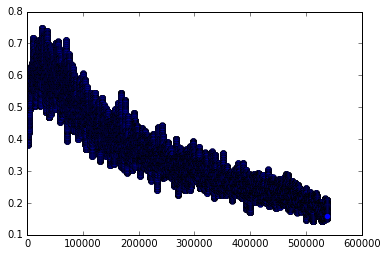

In [76]:
pyplot.show()

In [7]:
pyplot.plot(x_overall[x_overall.dupe_rate == -1]['timeline'], predictions, "o")

913011     0.000602
1691364    0.000947
1885921    0.001188
449153     0.001440
151948     0.001473
dtype: float64

In [8]:
df_test[0:10]

,test_id,question1,question2,qid1,qid2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,537934,537935
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,537936,537937
2,2,What but is the best way to send money from Ch...,What you send money to China?,537938,537939
3,3,Which food not emulsifiers?,What foods fibre?,537940,537941
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,537942,537943
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...,537944,537945
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?,74513,537946
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...,537947,537948
8,8,What are the how best books of all time?,What are some of the military history books of...,537949,537950
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?,537951,537952
